In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from transformers import GPT2Model, GPT2Tokenizer

# vector plots
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
# load GPT2 model and tokenizer
model = GPT2Model.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# use GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# move the model to the GPU
model = model.to(device)
model.eval() # we're training the embeddings, not the model!


# a copy of the original embeddings
embeddings = model.wte.weight.detach().cpu()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
# length of the token sequence
seq_len = 15

# random embeddings with gradient tracking
optimized_embeddings = torch.randn((1, seq_len, embeddings.shape[1]), requires_grad=True, device=device)

# normalize the std to that of the real embeddings matrix
torch.nn.init.normal_(optimized_embeddings, mean=0, std=torch.std(embeddings))

# check the shape
optimized_embeddings.shape

torch.Size([1, 15, 768])

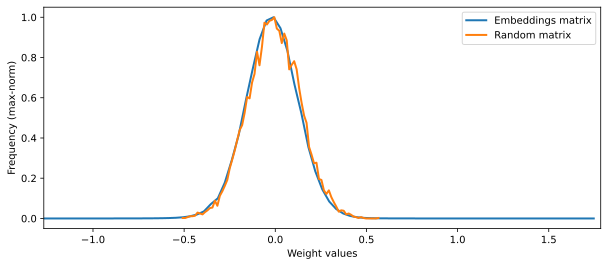

In [4]:
# get the histogram values
ye,xe = np.histogram(embeddings.flatten(),bins=80)
yo,xo = np.histogram(optimized_embeddings.flatten().detach().cpu(),bins=80)

plt.figure(figsize=(10,4))
plt.plot(xe[:-1],ye/np.max(ye),linewidth=2,label='Embeddings matrix')
plt.plot(xo[:-1],yo/np.max(yo),linewidth=2,label='Random matrix')

plt.legend()
plt.gca().set(xlabel='Weight values',ylabel='Frequency (max-norm)',xlim=xe[[0,-1]])
# plt.yscale('log') # optional, gives a better appreciation of the tails
plt.show()

In [5]:
# select a dimension to maximize
layer_idx = 10 # 8th transformer block with index 7
dim_idx = 100

In [6]:
# how to use the maximized embeddings
outputs = model(
    inputs_embeds = optimized_embeddings, # instead of input_ids
    output_hidden_states = True # request all activations exported
    )

# the output
print(f'Size of outputs.hidden_states: {len(outputs.hidden_states)}')
print(f'e.g., size of activation from layer {layer_idx}: {outputs.hidden_states[layer_idx].shape}')

Size of outputs.hidden_states: 13
e.g., size of activation from layer 10: torch.Size([1, 15, 768])


In [7]:
n_steps = 500   # optimization steps
lr = .001       # learning rate
lambda_l2 = .01 # regularization amount

# optimizer
optimizer = torch.optim.Adam([optimized_embeddings], lr=lr)

In [8]:
# train
# initialize vectors to store progress
activationVal = np.zeros(n_steps)
gradientNorm = np.zeros(n_steps)


# loop over training steps
for step in range(n_steps):

  # clear gradient
  optimizer.zero_grad()

  # patch embeddings directly into the model
  outputs = model(
      inputs_embeds = optimized_embeddings,
      output_hidden_states = True)

  # extract the dimension's activation (averaged over tokens)
  allActivations = outputs.hidden_states[layer_idx]
  dim_activation = allActivations[0,:,dim_idx].mean()

  # squared Euclidean distance for L2 normalization
  L2 = lambda_l2 * torch.sum(optimized_embeddings**2)

  # minimize loss -> maximize activation
  loss = -dim_activation + L2
  activationVal[step] = dim_activation.item()


  # run gradient descent
  loss.backward()

  # get the gradient norm
  gradientNorm[step] = optimized_embeddings.grad.norm().item()

  # finish backprop
  optimizer.step()

  if step%23==0:
    print(f'Step {step:4}/{n_steps}, Target activation: {activationVal[step]:6.2f} (vs. neighbor: {allActivations[0,:,dim_idx+1].mean():.2f})')

Step    0/500, Target activation:  -0.73 (vs. neighbor: 2.83)
Step   23/500, Target activation:  13.22 (vs. neighbor: 1.83)
Step   46/500, Target activation:  31.97 (vs. neighbor: -0.09)
Step   69/500, Target activation:  54.17 (vs. neighbor: -3.93)
Step   92/500, Target activation:  73.55 (vs. neighbor: -2.82)
Step  115/500, Target activation:  91.90 (vs. neighbor: -1.22)
Step  138/500, Target activation: 106.54 (vs. neighbor: -1.97)
Step  161/500, Target activation: 117.62 (vs. neighbor: -3.89)
Step  184/500, Target activation: 127.60 (vs. neighbor: -5.11)
Step  207/500, Target activation: 136.53 (vs. neighbor: -4.83)
Step  230/500, Target activation: 144.05 (vs. neighbor: -4.89)
Step  253/500, Target activation: 151.03 (vs. neighbor: -5.46)
Step  276/500, Target activation: 157.11 (vs. neighbor: -5.24)
Step  299/500, Target activation: 163.12 (vs. neighbor: -4.55)
Step  322/500, Target activation: 168.56 (vs. neighbor: -4.01)
Step  345/500, Target activation: 173.42 (vs. neighbor: -

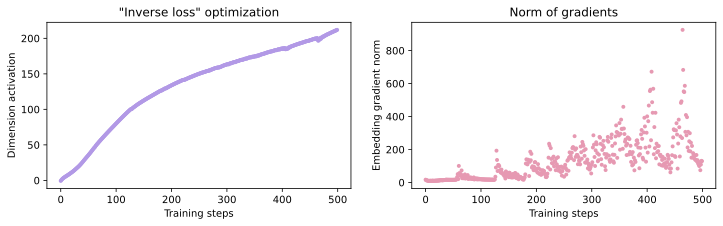

In [9]:
_,axs = plt.subplots(1,2,figsize=(12,3))

# plot the activation magnitudes
axs[0].plot(activationVal,'o',markersize=4,markerfacecolor=[.7,.6,.9],markeredgecolor='none')
axs[0].set(xlabel='Training steps',ylabel='Dimension activation',title='"Inverse loss" optimization')

# plot the gradient norms
axs[1].plot(gradientNorm,'o',markersize=4,markerfacecolor=[.9,.6,.7],markeredgecolor='none')
axs[1].set(xlabel='Training steps',ylabel='Embedding gradient norm',title='Norm of gradients')

plt.show()

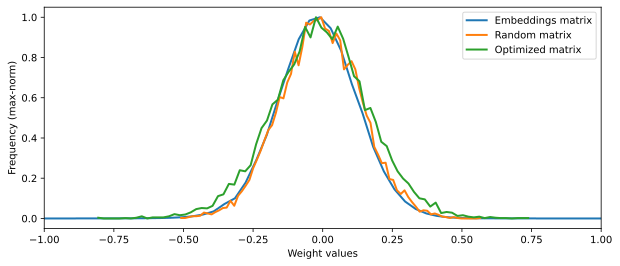

In [10]:
# redraw the histograms of embedding values

# get the histogram values
yo2,xo2 = np.histogram(optimized_embeddings.flatten().detach().cpu(),bins=80)

plt.figure(figsize=(10,4))
plt.plot(xe[:-1],ye/np.max(ye),linewidth=2,label='Embeddings matrix')
plt.plot(xo[:-1],yo/np.max(yo),linewidth=2,label='Random matrix')
plt.plot(xo2[:-1],yo2/np.max(yo2),linewidth=2,label='Optimized matrix')

plt.legend()
plt.gca().set(xlabel='Weight values',ylabel='Frequency (max-norm)',
              xlim=[-1,1])
plt.show()

In [11]:
plt.figure(figsize=(10,4))
plt.imshow(optimized_embeddings.squeeze().detach().cpu(),
           aspect='auto',vmin=-.3,vmax=.3,origin='lower')

plt.gca().set(xlabel='Embedding dim.',ylabel='Token position')
plt.show()

In [12]:
# Pre-normalize all embeddings for fast dot-product similarity
embeddings_norm = F.normalize(embeddings, p=2, dim=-1)


In [15]:
# one embed
oneemb = optimized_embeddings[0][1].detach().cpu()

# cosine similarity with all embedding vectors
#cs = F.cosine_similarity(oneemb.unsqueeze(0), embeddings)
oneemb_norm = F.normalize(oneemb.unsqueeze(0), p=2, dim=-1)
# Result is exact cosine similarity
cs = torch.mm(oneemb_norm, embeddings_norm.T).squeeze()


# find the token with max cossim
#maxtok = np.argmax(cs)
maxtok = torch.argmax(cs).item() # Stay on GPU as long as possible

# and visualize
plt.figure(figsize=(10,4))
plt.plot(cs,'ko',markerfacecolor=[.9,.7,.8,.6])
plt.gca().set(xlim=[-10,tokenizer.vocab_size+9],xlabel='Token index',ylabel='Cosine similarity',
              title=f'Similarities to all token embeddings (top token is "{tokenizer.decode(maxtok)}")')
plt.show()

In [11]:
# how to decode embeddings to the closest tokens this script is not providing me the solution
# provide me with the full script that provide the solution if posible in this method
optimized_tokens = []

for emb in optimized_embeddings[0]:

  # cosine similarity with embedding weights
  similarities = F.cosine_similarity(emb.unsqueeze(0).detach().cpu(), embeddings)

  # find the max similarity
  maxtok = np.argmax(similarities)
  optimized_tokens.append(maxtok)

print('Optimized token sequence:\n',tokenizer.decode(optimized_tokens))

Optimized token sequence:
 rationsrost SystemMods Assetcciistanceent sympathouri guiActiveUnfocused Cons contempor fragrance contempor


In [12]:
# 1. Prepare weights (do this once) AI Generated file
# Ensure embeddings are on GPU for the calculation
emb_weights_gpu = embeddings.to(optimized_embeddings.device)
# Normalize vocab weights for cosine similarity
emb_weights_norm = F.normalize(emb_weights_gpu, p=2, dim=1)

# 2. Vectorized Decoding (The solution to your speed issue)
# Flatten the optimized embeddings [batch, seq, dim] -> [total_tokens, dim]
flat_optimized = optimized_embeddings.view(-1, optimized_embeddings.shape[-1])
flat_optimized_norm = F.normalize(flat_optimized, p=2, dim=1)

# Compute ALL similarities at once via Matrix Multiplication
# Resulting shape: [total_tokens, vocab_size]
all_similarities = torch.mm(flat_optimized_norm, emb_weights_norm.T)

# Find the max token for all positions at once
optimized_tokens = torch.argmax(all_similarities, dim=1).cpu().tolist()

# 3. Final Output
print('Optimized token sequence:\n', tokenizer.decode(optimized_tokens))


Optimized token sequence:
 rationsrost SystemMods Assetcciistanceent sympathouri guiActiveUnfocused Cons contempor fragrance contempor


In [13]:
#AI Generated file
import torch
import torch.nn.functional as F

def decode_optimized_embeddings(optimized_embeddings, embeddings_weight, tokenizer):
    """
    Decodes a batch of embeddings to the nearest tokens using vectorized cosine similarity.

    Args:
        optimized_embeddings: Tensor of shape [batch, seq_len, emb_dim]
        embeddings_weight: The model's embedding matrix [vocab_size, emb_dim]
        tokenizer: The tokenizer for decoding indices to text
    """
    # 1. Ensure everything is on the same device (GPU)
    device = optimized_embeddings.device
    embeddings_weight = embeddings_weight.to(device)

    # 2. Normalize weights for Cosine Similarity (Vectorized)
    # This turns Cosine Similarity into a simple Dot Product
    emb_norm = F.normalize(embeddings_weight, p=2, dim=1)  # [vocab_size, dim]

    # Flatten batch and sequence for bulk processing
    flat_optimized = optimized_embeddings.view(-1, optimized_embeddings.shape[-1])
    flat_optimized_norm = F.normalize(flat_optimized, p=2, dim=1) # [seq_len, dim]

    # 3. Calculate all similarities at once using Matrix Multiplication
    # [seq_len, dim] @ [dim, vocab_size] -> [seq_len, vocab_size]
    similarities = torch.matmul(flat_optimized_norm, emb_norm.T)

    # 4. Get the max token index for every position in the sequence at once
    optimized_token_ids = torch.argmax(similarities, dim=1)

    # 5. Move to CPU only once at the very end
    token_ids_list = optimized_token_ids.cpu().tolist()

    # 6. Decode the full sequence
    decoded_text = tokenizer.decode(token_ids_list)

    return token_ids_list, decoded_text

# --- USAGE ---
# Assuming 'embeddings' is your model's weight matrix (e.g., model.get_input_embeddings().weight)
token_ids, text = decode_optimized_embeddings(optimized_embeddings, embeddings, tokenizer)

print('Optimized token sequence IDs:', token_ids)
print('Optimized text:', text)


Optimized token sequence IDs: [9143, 23341, 4482, 24239, 31433, 35764, 9311, 298, 23860, 10300, 30210, 3515, 36081, 36860, 36081]
Optimized text: rationsrost SystemMods Assetcciistanceent sympathouri guiActiveUnfocused Cons contempor fragrance contempor
